### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from matplotlib import cm
import re
from sklearn import preprocessing, tree, ensemble, linear_model, metrics, model_selection, svm
import xgboost

In [2]:
spray = pd.read_csv('assets/spray.csv')
weather = pd.read_csv('assets/weather.csv')
test = pd.read_csv('assets/west-nile-test.csv')
train = pd.read_csv('assets/west-nile-train.csv')

In [3]:
#dates should be in date-time format for easy wrangling
for i in [spray, weather, test, train]:
    i.Date = pd.to_datetime(i.Date, format='%Y-%m-%d')

### Weather Data - cleaning and wrangling

In [4]:
#many variables are currently objects because they have things like "M" for missing. Must convert.
to_numericize = ['Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
                 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
for col in to_numericize:
    weather[col] = pd.to_numeric(weather[col], errors='coerce')

In [5]:
#for sunrise times and sunset times to be interpreted properly, converting to hours
def twentyfour_hour_to_float(HHMM):
    if HHMM == '-':
        return np.NaN
    else:
        hour = float(HHMM[:2])
        minute = float(HHMM[2:])
        return hour + minute/60
weather.Sunrise = weather.Sunrise.apply(twentyfour_hour_to_float)
weather.Sunset = weather.Sunset.apply(twentyfour_hour_to_float)

#calculate hours in day
weather['hours_in_day'] = weather.Sunset - weather.Sunrise

In [6]:
#Depth, Water1, and SnowFall are all useless variables (all or almost all Nan).
weather.drop(['Depth', 'Water1', 'SnowFall'], axis=1, inplace=True)

In [7]:
#functions to combine data from Station 1 and Station 2, where applicable
def avg_wind_direction(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    elif np.abs(S1-S2) > 18:
        if S1<S2:
            S1+=36
        else:
            S2+=36
        avg = (S1+S2)/2.0
    else:
        avg = (S1+S2)/2.0
    if avg >=36:
        avg-=36
    return avg
def combine_conditions(S1, S2):
    if S1 == " " and S2 == " ":
        return ""
    elif S1 == " " and S2 != " ":
        return S2
    elif S1 != " " and S2 == " ":
        return S1
    else:
        S1_list = S1.split(" ")
        S2_list = S2.split(" ")
        return list(set(S1_list + S2_list))
def avg_col(S1, S2):
    if S1 == np.NaN:
        avg = float(S2)
    elif S2 == np.NaN:
        avg = float(S1)
    else: 
        avg=(S1+S2)/2.0
    return avg

In [8]:
combined_weather = pd.DataFrame()

s1 = weather[weather.Station==1]
s2 = weather[weather.Station==1]

#columns that only have data for Station 1 or the data are the same.
for col in ['Date', 'Depart', 'Sunrise', 'Sunset', 'hours_in_day']:
    combined_weather[col] = s1[col].values

#application of averaging function
for col in ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'AvgSpeed']:
    combined_weather[col] = [avg_col(a, b) for a, b in zip(s1[col].values, s2[col].values)]

#application of unique functions
combined_weather['ResultDir'] = [avg_wind_direction(a, b) for a, b in zip(s1.ResultDir.values, s2.ResultDir.values)]
combined_weather['CodeSum'] = [combine_conditions(a, b) for a, b in zip(s1.CodeSum.values, s2.CodeSum.values)]

#PrecipTotal for each station is too different -- keeping both
combined_weather['PrecipTotal_station1'] = weather.PrecipTotal[weather.Station==1].values
combined_weather['PrecipTotal_station2'] = weather.PrecipTotal[weather.Station==2].values

In [9]:
#Unable to accurately impute for PrecipTotals and too much missing, so starting by dropping those columns
combined_weather.drop(['PrecipTotal_station1', 'PrecipTotal_station2'], axis=1, inplace=True)

In [10]:
#impute missing data for.

#WetBulb
X = combined_weather.dropna().drop(['Date', 'WetBulb', 'CodeSum'], axis=1)
y = combined_weather.dropna()['WetBulb']

dt_WetBulb = ensemble.RandomForestRegressor(n_estimators=100)
dt_WetBulb.fit(X, y)

subset = combined_weather.columns.drop('WetBulb')
predicted_WetBulb = dt_WetBulb.predict(combined_weather.dropna(subset=subset).drop(['Date', 'WetBulb', 'CodeSum'], axis=1)[combined_weather.WetBulb.isnull()])

combined_weather.WetBulb[combined_weather.WetBulb.isnull()] = predicted_WetBulb

#StnPressure
X = combined_weather.dropna().drop(['Date', 'StnPressure', 'CodeSum'], axis=1)
y = combined_weather.dropna(subset=subset)['StnPressure']

xb_StnPressure = xgboost.XGBRegressor()
xb_StnPressure.fit(X, y)

predicted_StnPressure = xb_StnPressure.predict(combined_weather.drop(['Date', 'StnPressure', 'CodeSum'], axis=1)[combined_weather.StnPressure.isnull()])

combined_weather.StnPressure[combined_weather.StnPressure.isnull()] = predicted_StnPressure

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Train/Test Data - cleaning and wrangling

In [11]:
#pull out zip codes from address
def find_zip(address):
    if re.search('(?<=IL )[0-9]*', address):
        return re.search('(?<=IL )[0-9]*', address).group(0)
train['zip_code'] = train.Address.apply(find_zip)

In [12]:
# Address, Street, and AddressNumberAndStreet give essentially the same information as Trap, so they can be deleted
train.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

In [13]:
#impute missing zips
X = train.dropna()[['Latitude', 'Longitude']]
y = train.dropna()['zip_code']

dtree_forzip = tree.DecisionTreeClassifier()
dtree_forzip.fit(X, y)
predicted_zip = dtree_forzip.predict(train[['Latitude', 'Longitude']][train.zip_code.isnull()])

train.zip_code[train.zip_code.isnull()] = predicted_zip

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# create columns for day of year, month, day of week:
train['day_of_year'] = train.Date.dt.dayofyear
train['month'] = train.Date.dt.month
train['day_of week'] = train.Date.dt.dayofweek
train['year'] = train.Date.dt.year

In [15]:
#repeat all with test data
test['zip_code'] = test.Address.apply(find_zip)
test.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)

predicted_zip = dtree_forzip.predict(test[['Latitude', 'Longitude']][test.zip_code.isnull()])

test.zip_code[test.zip_code.isnull()] = predicted_zip
test['day_of_year'] = test.Date.dt.dayofyear
test['month'] = test.Date.dt.month
test['day_of week'] = test.Date.dt.dayofweek
test['year'] = test.Date.dt.year

/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# putting various weights to the traps
num_by_trap = pd.groupby(train[['Trap', 'NumMosquitos', 'WnvPresent']], 'Trap').agg('sum') 
num_by_trap['trap_percent_of_all_mosquitos'] = num_by_trap['NumMosquitos']/sum(num_by_trap.NumMosquitos)
num_by_trap['trap_percent_with_wnv'] = num_by_trap.WnvPresent/num_by_trap.NumMosquitos
num_by_trap.reset_index(inplace=True)

map_mosq_weight = {t:v for t, v in zip(num_by_trap.Trap.values, num_by_trap['trap_percent_of_all_mosquitos'].values)}
map_wnv_weight = {t:v for t, v in zip(num_by_trap.Trap.values, num_by_trap['trap_percent_with_wnv'].values)}

map_wnv_weight2 = {}
for trap in set(train.Trap):
    map_wnv_weight2[trap] = sum(train.WnvPresent[train.Trap==trap]/sum(train.Trap==trap))
map_wnv_weight2

train['trap_percent_of_all_mosquitos'] = train.Trap.map(map_mosq_weight)
train['trap_percent_with_wnv'] = train.Trap.map(map_wnv_weight)
train['trap_percent_with_wnv2'] = train.Trap.map(map_wnv_weight2)

In [17]:
# Repeat on test data
test['trap_percent_of_all_mosquitos'] = test.Trap.map(map_mosq_weight).fillna(0)
test['trap_percent_with_wnv'] = test.Trap.map(map_wnv_weight).fillna(0)
test['trap_percent_with_wnv2'] = test.Trap.map(map_wnv_weight2).fillna(0)

### Merge

In [18]:
train_w = pd.merge(train, combined_weather, how='left', on='Date')
test_w = pd.merge(test, combined_weather, how='left', on='Date')

### Preprocessing

In [19]:
# Have to pre-process label-encoder on test set because test set has more traps and species.
le_trap = preprocessing.LabelEncoder()
test_w['Trap_num'] = le_trap.fit_transform(test_w.Trap)

# le_species = preprocessing.LabelEncoder()
# test_w['Species_num'] = le_species.fit_transform(test_w.Species)

le_zip = preprocessing.LabelEncoder()
test_w['zip_code_num'] = le_zip.fit_transform(test_w.zip_code)

In [20]:
#repeat with Train
train_w['Trap_num'] = le_trap.transform(train_w.Trap)

# train_w['Species_num'] = le_species.transform(train_w.Species)

train_w['zip_code_num'] = le_zip.transform(train_w.zip_code)

In [21]:
# MultiLabelBinarizer on Codesum
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(test_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

test_w = pd.concat([test_w, mlb_df], axis=1)

In [22]:
# repeat with test
mlb = preprocessing.MultiLabelBinarizer()
mlb_mat = mlb.fit_transform(train_w.CodeSum)
mlb_df = pd.DataFrame(mlb_mat, columns=mlb.classes_)

train_w = pd.concat([train_w, mlb_df], axis=1)

## Model Selection

In [23]:
X = train_w.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code'.split(' '), axis=1)
y = train_w.WnvPresent

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)

In [25]:
#Decision Tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predict = dtree.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.68445280146581366

In [26]:
#Random Forrest
clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100)
clf.fit(X_train, y_train)
predict = clf.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.79218775441342926

In [27]:
#AdaBoost
ada = ensemble.AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

predict = ada.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.85447404713281583

In [28]:
#XGBoost
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train, y_train)

predict = xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.86737053973410538

In [29]:
#Extra Trees
et = tree.ExtraTreeClassifier()
et.fit(X_train, y_train)
predict = dtree.predict_proba(X_test)
metrics.roc_auc_score(y_test, predict[:,1])

0.68445280146581366

In [30]:
pd.DataFrame(xgb.feature_importances_, index=X.columns).sort_values(by=0, ascending=False)

,0
day_of_year,0.186688
trap_percent_with_wnv2,0.137987
year,0.071429
trap_percent_of_all_mosquitos,0.069805
Longitude,0.068182
AvgSpeed,0.056818
trap_percent_with_wnv,0.042208
ResultDir,0.034091
Latitude,0.034091
Tmax,0.034091


In [31]:
#Cross-validated scores
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
for model, name in zip([clf, ada, xgb, et], ['clf', 'ada', 'xgb', 'et']):
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    print name, score.mean(), '+/-', score.std()

clf 0.781715738843 +/- 0.027867372367
ada 0.848534930529 +/- 0.0153815646951
xgb 0.857952012558 +/- 0.0196446463475
et 0.676269206515 +/- 0.0175921600514


In [32]:
#Grid-Search to find best parameters
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = model_selection.GridSearchCV(xgboost.XGBClassifier(), param_grid={
        'max_depth':[3,4,5,6, 7],
        'learning_rate':[.04, .06, .08, .1, .12, .14, .16],
    },scoring='roc_auc', cv=cv)
xg_best.fit(X, y).best_params_

# cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
xg_best = xgboost.XGBRegressor(learning_rate=0.14, max_depth=3)
score = model_selection.cross_val_score(xg_best, X, y, cv=cv, scoring='roc_auc')
print 'score:',score.mean(),"+/-",score.std()

score: 0.839272191693 +/- 0.0136219346401


Didn't perform any better, so we will keep with the simple model. 

In [33]:
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=5)
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
predictions = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv)
metrics.roc_auc_score(y, predict[:,1])

0.8564905960670568

AUC: 0.854760396375


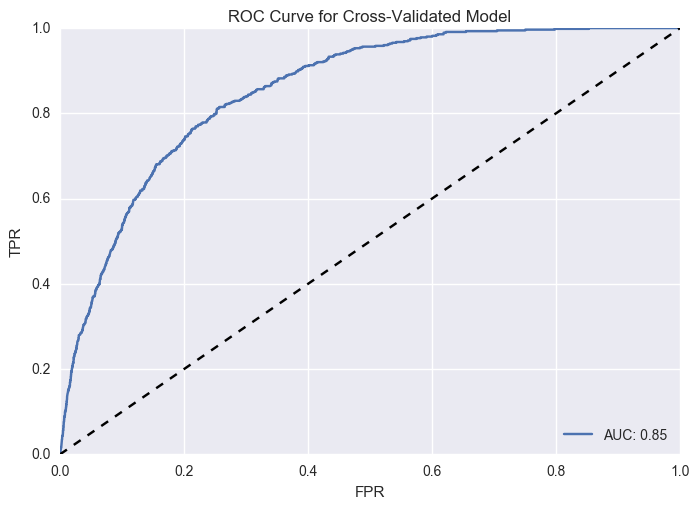

In [34]:
predict = model_selection.cross_val_predict(xgboost.XGBClassifier(), X, y, cv=cv, method='predict_proba')
y_score = predict[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_score)
print 'AUC:', metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC: {:.2}'.format(metrics.auc(fpr, tpr)))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Cross-Validated Model')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')

## Threshold Manipulation
Because the threshold must be set very low to pick up on a significant number of traps with west nile virus, I have set certain True Positive Rate thresholds to explore further.

In [35]:
# thresholds for TPR of 80%, 85%, 90%, 95%, and 100%
thresh = [[th for t, f, th in zip(tpr, fpr, thresholds) if t >= i][0] for i in [.8, .85, .9, .95, 1]]

In [36]:
# Print classification reports for each threshold corresponding to the TPRs above.
for i in thresh:
    predictions = [1 if p >= i else 0 for p in y_score]
    print 'threshold:', i
    print metrics.classification_report(y, predictions)
    print ''

threshold: 0.0557148
             precision    recall  f1-score   support

          0       0.99      0.75      0.85      9955
          1       0.15      0.80      0.25       551

avg / total       0.94      0.75      0.82     10506


threshold: 0.0413744
             precision    recall  f1-score   support

          0       0.99      0.69      0.81      9955
          1       0.13      0.85      0.23       551

avg / total       0.94      0.69      0.78     10506


threshold: 0.0301775
             precision    recall  f1-score   support

          0       0.99      0.62      0.76      9955
          1       0.11      0.90      0.20       551

avg / total       0.95      0.63      0.73     10506


threshold: 0.019512
             precision    recall  f1-score   support

          0       0.99      0.53      0.69      9955
          1       0.10      0.95      0.18       551

avg / total       0.95      0.55      0.66     10506


threshold: 0.00113097
             precision    recal

In [37]:
# Print confusion matrix for each threshold corresponding to the TPRs above.
for i in thresh:
    predictions = [1 if p >= i else 0 for p in y_score]
    print 'threshold:', i
    print metrics.confusion_matrix(y, predictions)
    print ''

threshold: 0.0557148
[[7446 2509]
 [ 110  441]]

threshold: 0.0413744
[[6832 3123]
 [  82  469]]

threshold: 0.0301775
[[6134 3821]
 [  55  496]]

threshold: 0.019512
[[5255 4700]
 [  27  524]]

threshold: 0.00113097
[[1464 8491]
 [   0  551]]



In [38]:
# Print average yearly savings associated with each threshold, based on an assumed $500 per test
for i in thresh:
    p = [1 if p >= i else 0 for p in y_score]
    print (metrics.confusion_matrix(y, p)[0,0] + metrics.confusion_matrix(y, p)[1,0])*500/4

944500
864250
773625
660250
183000


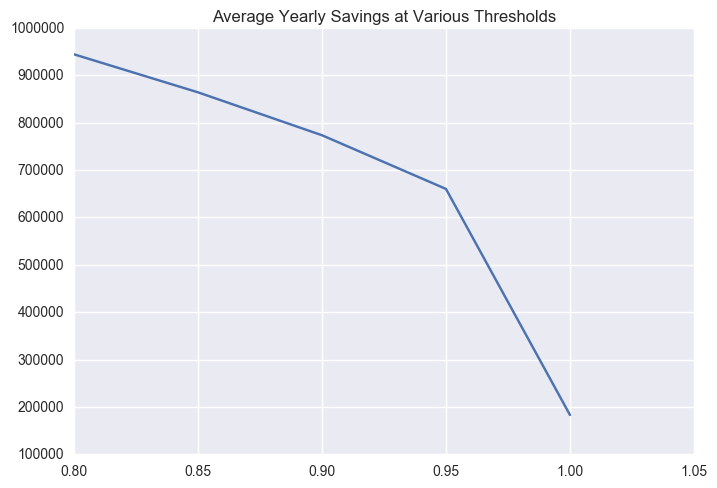

In [40]:
# Graphing savings at each TPR rate
recall = [.8, .85, .9, .95, 1]
savings = [944500, 864250, 773625, 660250, 183000]
plt.plot(recall, savings)
plt.title("Average Yearly Savings at Various Thresholds")

### Kaggle Submission

In [42]:
X = train_w.drop('Date Trap Species CodeSum NumMosquitos WnvPresent zip_code VCTS FG'.split(' '), axis=1)
y = train_w.WnvPresent
X_testset = test_w.drop('Date Trap Species CodeSum zip_code Id BCFG FG+'.split(' '), axis=1)
xgb.fit(X, y)
FINAL = xgb.predict_proba(X_testset)[:,1]

In [43]:
sample = pd.read_csv('assets/sampleSubmission.csv', index_col='Id')

In [44]:
sample.WnvPresent = FINAL

In [45]:
sample.to_csv('assets/testSubmission.csv')